In [26]:
%load_ext autoreload
%autoreload 2

import sys, os
import numpy as np
import math

os.environ['CUDA_VISIBLE_DEVICES'] = '2'
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.utils.data as data
from math import isnan
import math
import matplotlib.pyplot as plt

from argparse import Namespace
import pandas,pickle,warnings
warnings.filterwarnings("ignore")

from src.models import *
from src.utils import *
import argparse
import matplotlib.patches as mpatches
from sklearn.svm import SVC
from src.dataloader import TabDataset

from src import eval_utils
import time
from sklearn.manifold import TSNE 
from aif360.datasets import AdultDataset, GermanDataset, CompasDataset
from sklearn.preprocessing import scale, StandardScaler, MaxAbsScaler
import matplotlib.colors as colors


min_max_scaler = MaxAbsScaler()
std_scaler = StandardScaler()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
np.random.seed(0)
#dataset = {'adult' : AdultDataset(), 'german' : GermanDataset(),'bank': BankDataset(),'compas' : CompasDataset(),'celeb': CelebADataset()}
dataset = {'adult' : AdultDataset(), 'german' : GermanDataset(),'compas' : CompasDataset()}
dataset['german'].labels -= 1
sens_attr_dict = {'adult': ['sex', 'race'], 'german' : ['sex', 'age'], 'compas' : ['sex', 'race']}


In [28]:
data_name = 'adult'
protected_attribute_used = 3

In [29]:
if data_name == "adult":
    dataset_orig = AdultDataset()
    # #dataset_orig = load_preproc_data_adult()
    if protected_attribute_used == 1:
        sens_attr = 'sex'
    elif protected_attribute_used == 2:
        sens_attr = 'race'
    elif protected_attribute_used == 3: #intersectional
        sens_attr = ['sex', 'race']

elif data_name == "german":
    dataset_orig = GermanDataset()
    dataset_orig.labels = dataset_orig.labels-1
    if protected_attribute_used == 1:
        sens_attr = 'sex'
    elif protected_attribute_used == 2:
        sens_attr = 'age'
    elif protected_attribute_used == 3: #intersectional
        sens_attr = ['sex', 'age']

elif data_name == "compas":
    dataset_orig = CompasDataset()
    # #dataset_orig = load_preproc_data_compas()
    if protected_attribute_used == 1:
        sens_attr = 'race'
    elif protected_attribute_used == 2:
        sens_attr = 'sex'
    elif protected_attribute_used == 3: #intersectional
        sens_attr = ['race', 'sex']


In [31]:
sens_idx = [dataset[data_name].feature_names.index(attr) for attr in sens_attr]
num_sens = len(np.unique(dataset[data_name].features[:, sens_idx]))

bs = 128
workers = 16
device = 'cuda:0'

feature_size = dataset[data_name].features.shape[1]
sens_loc = np.zeros(feature_size).astype(bool)
sens_loc[sens_idx] = 1

feature = dataset[data_name].features[:,~sens_loc] #data without sensitive
if data_name == 'german':
    feature = std_scaler.fit_transform(feature)
    
dataset[data_name].features[:,~sens_loc] = feature

data_train, data_vt = dataset[data_name].split([0.7], shuffle=True)
data_valid, data_test = data_vt.split([0.5], shuffle=True)

d_train = TabDataset(data_train, sens_idx, norm = False if data_name == 'german' else True)
v_train = TabDataset(data_valid, sens_idx, norm = False if data_name == 'german' else True)
t_train = TabDataset(data_test, sens_idx, norm = False if data_name == 'german' else True)

trainloader = torch.utils.data.DataLoader(
    d_train,
    batch_size=bs,
    shuffle=True,
    num_workers = 16
    )

validloader = torch.utils.data.DataLoader(
    v_train,
    batch_size=bs,
    shuffle=True,
    num_workers = 16
    )

testloader = torch.utils.data.DataLoader(
    t_train,
    batch_size=bs,
    shuffle=True,
    num_workers = 16
    )
input_dim = dataset[data_name].features.shape[1] - 1


## Baseline

In [32]:
import torch.nn.init as init

def weights_init_kaiming(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
    elif classname.find('Linear') != -1:
        init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
    elif classname.find('BatchNorm') != -1:
        init.normal(m.weight.data, 1.0, 0.02)
        init.constant(m.bias.data, 0.0)
        
class Classifier(nn.Module):
    def __init__(self, input_dim = 32, hidden_dim = 128, output_dim = 1):
        super(Classifier, self).__init__()
        self.input_dim = input_dim
        self.relu = nn.LeakyReLU(0.2)
        self.dense1 = nn.Linear(input_dim, hidden_dim)
        self.dense2 = nn.Linear(hidden_dim, hidden_dim)
        self.dense3 = nn.Linear(hidden_dim, output_dim)
        
        for m in self.children():
            weights_init_kaiming(m)
        
    def forward(self, x):
        x = self.relu(self.dense1(x))
        # x = self.relu(self.dense2(x))
        x = self.dense3(x)
        return x

In [33]:
base = Classifier(input_dim = feature.shape[-1], hidden_dim = 32 if data_name == 'german' else 128).cuda()
# German
# base = Classifier(input_dim = feature.shape[-1], hidden_dim = 32).cuda()
optim_base = optim.Adam(base.parameters(), lr = 5e-5, weight_decay =1e-4)
criterion = nn.BCEWithLogitsLoss()

In [34]:
epochs = 200

for epoch in (range(epochs + 1)):
    base.train()

    loss_hist = 0
    cnt = 0
    
    for x_batch, s_batch, y_batch in trainloader:
        x_batch = x_batch.cuda().float()
        s_batch, y_batch = s_batch.cuda().view(-1,1).float(), y_batch.cuda().view(-1,1).float()
        
        pred_y = base(x_batch)

        loss = criterion(pred_y, y_batch)
        
        optim_base.zero_grad()
        loss.backward()
        optim_base.step()
        
        loss_hist += loss.item()
        cnt += 1

    diag = "[TRAIN] epoch : [{}/{}]\n".format(epoch, epochs)
    diag += "Loss : {:.3f}\n".format(loss_hist/cnt)
    if epoch % 10 == 0:
        print(diag)
        evaluate()


[TRAIN] epoch : [0/200]
Loss : 0.668

ACC : 0.772, ACC_group : [0.9170616113744076, 0.7889908256880734, 0.8729096989966555, 0.708851317752362]
TPR : 0.209, TPR_group : [0.19444444444444445, 0.2204724409448819, 0.22171945701357465, 0.2063253012048193]
FPR : 0.038, FPR_group : [0.015544041450777202, 0.03827751196172249, 0.03560076287349015, 0.043429844097995544]
DP : 0.000, EOP : 0.027, EOd : 0.055
[TRAIN] epoch : [10/200]
Loss : 0.512

ACC : 0.772, ACC_group : [0.9170616113744076, 0.7889908256880734, 0.8729096989966555, 0.708851317752362]
TPR : 0.209, TPR_group : [0.19444444444444445, 0.2204724409448819, 0.22171945701357465, 0.2063253012048193]
FPR : 0.038, FPR_group : [0.015544041450777202, 0.03827751196172249, 0.03560076287349015, 0.043429844097995544]
DP : 0.000, EOP : 0.027, EOd : 0.055
[TRAIN] epoch : [20/200]
Loss : 0.501

ACC : 0.774, ACC_group : [0.8981042654028436, 0.7871559633027523, 0.8639910813823858, 0.718299353555445]
TPR : 0.309, TPR_group : [0.2777777777777778, 0.2834645

In [35]:
def evaluate():
    base.eval()
    with torch.no_grad():
        prob_lst, pred_lst, y_lst, a_lst = [], [], [], []
        for x_batch, s_batch, y_batch in validloader:
            x_batch, s_batch, y_batch = x_batch.cuda().float(), s_batch.cuda().float().view(-1,1), y_batch.cuda().float().view(-1,1)

            pred = base(x_batch)

            pred[pred>=0] = 1
            pred[pred<0] = 0

            pred_lst.append(pred.detach())
            y_lst.append(y_batch.detach())
            a_lst.append(s_batch.detach())

        pred_lst = torch.cat(pred_lst).cpu().numpy()
        y_lst = torch.cat(y_lst).cpu().numpy()
        a_lst = torch.cat(a_lst).cpu().numpy()
        pos_idx = y_lst == 1

        acc = (pred_lst == y_lst).mean()
        acc_group = [(pred_lst[a_lst == s] == y_lst[a_lst == s]).mean() for s in range(4)]

        tpr = (pred_lst[pos_idx] == 1).mean()
        tpr_group = [(pred_lst[pos_idx*(a_lst == s)] == 1).mean() for s in range(4)]

        fpr = (pred_lst[~pos_idx] == 1).mean()
        fpr_group = [(pred_lst[~pos_idx*(a_lst == s)] == 1).mean() for s in range(4)]

        DP = abs(max([(pred_lst[s]==1).mean() for s in range(4)]) - min([(pred_lst[s]==1).mean() for s in range(4)]))
        EOP =abs(max(tpr_group)-min(tpr_group))
        EOD =abs(max(tpr_group)-min(tpr_group)) + abs(max(fpr_group)-min(fpr_group))
        
        diag = "ACC : {:.3f}, ACC_group : {}".format(acc, acc_group)
        print(diag)

        diag = "TPR : {:.3f}, TPR_group : {}".format(tpr, tpr_group)
        print(diag)

        diag = "FPR : {:.3f}, FPR_group : {}".format(fpr, fpr_group)
        print(diag)

        diag = "DP : {:.3f}, EOP : {:.3f}, EOd : {:.3f}".format(DP, EOP, EOD)
        print(diag)

In [36]:
(pred_lst == 0).mean()

0.8248648648648649

In [37]:
'''
Baseline (Adult)
lr:1e-4
ACC : 0.830, ACC_group : [0.9014084507042254, 0.8551587301587301, 0.8914027149321267, 0.7936352509179927]
TPR : 0.615, TPR_group : [0.4642857142857143, 0.5849056603773585, 0.5799086757990868, 0.626615969581749]
FPR : 0.099, FPR_group : [0.0678391959798995, 0.0728643216080402, 0.0645577792123951, 0.12707581227436823]
DP : 0.000, EOP : 0.162, EOd : 0.225

Baseline(COMPAS)
lr:1e-3
ACC : 0.689, ACC_group : [0.674, 0.6890756302521008, 0.6964285714285714, 0.7733333333333333]
TPR : 0.571, TPR_group : [0.6450381679389313, 0.44565217391304346, 0.4666666666666667, 0.43478260869565216]
FPR : 0.213, FPR_group : [0.29411764705882354, 0.15753424657534246, 0.14925373134328357, 0.07692307692307693]
DP : 1.000, EOP : 0.210, EOd : 0.427

Baseline(German)
lr:1e-5
ACC : 0.767, ACC_group : [0.8, 1.0, 0.6774193548387096, 0.7676767676767676]
TPR : 0.175, TPR_group : [0.0, nan, 0.25, 0.15384615384615385]
FPR : 0.018, FPR_group : [0.0, 0.0, 0.05263157894736842, 0.0136986301369863]
DP : 1.000, EOP : 0.250, EOd : 0.303


'''

'\nBaseline (Adult)\nlr:1e-4\nACC : 0.830, ACC_group : [0.9014084507042254, 0.8551587301587301, 0.8914027149321267, 0.7936352509179927]\nTPR : 0.615, TPR_group : [0.4642857142857143, 0.5849056603773585, 0.5799086757990868, 0.626615969581749]\nFPR : 0.099, FPR_group : [0.0678391959798995, 0.0728643216080402, 0.0645577792123951, 0.12707581227436823]\nDP : 0.000, EOP : 0.162, EOd : 0.225\n\nBaseline(COMPAS)\nlr:1e-3\nACC : 0.689, ACC_group : [0.674, 0.6890756302521008, 0.6964285714285714, 0.7733333333333333]\nTPR : 0.571, TPR_group : [0.6450381679389313, 0.44565217391304346, 0.4666666666666667, 0.43478260869565216]\nFPR : 0.213, FPR_group : [0.29411764705882354, 0.15753424657534246, 0.14925373134328357, 0.07692307692307693]\nDP : 1.000, EOP : 0.210, EOd : 0.427\n\nBaseline(German)\nlr:1e-5\nACC : 0.767, ACC_group : [0.8, 1.0, 0.6774193548387096, 0.7676767676767676]\nTPR : 0.175, TPR_group : [0.0, nan, 0.25, 0.15384615384615385]\nFPR : 0.018, FPR_group : [0.0, 0.0, 0.05263157894736842, 0.0

## FSNS

In [38]:
parser = argparse.ArgumentParser("")
args = parser.parse_args("")

args.eta = 1e0
args.lamda = 1
args.gamma = 0.5
args.mu = 0.5

args.lr_h = 1e-4
args.lr_c = 1e-5
args.lr_p = 1e-4

args.latent = 64
args.hidden = 64

In [39]:
epochs = 200

input_size = feature.shape[-1]
num_sens = len(sens_idx)
num_group = 2**num_sens
latent_size = args.latent
hidden_size = args.hidden

FIG_EPOCH = 100
VIEW_FIG = False
SAVE_MODEL = False
TEST_EPOCH = 5
VIEW_EVAL = False


eta = args.eta
lamda = args.lamda
gamma = args.gamma
mu = args.mu


In [40]:
def max_margin_loss(y_onehot, y_pred, theta=0.3, mu=0.5, lamda=1):
    # theta, mu in (0, 1]
    
    # sample margin
    margin = y_pred[y_onehot==1] - y_pred[y_onehot==0]
    # average margin
    margin_mean = nn.MultiMarginLoss()(y_pred, y_onehot.argmax(-1))
    
    # nn.ReLU()
    
    xi = torch.relu(1 - margin - theta)
    epsilon = torch.relu(margin - 1 - theta)

    margin_var = lamda * torch.mean((xi**2 + mu * epsilon ** 2)/((1-theta)**2))
    
    return margin_mean, margin_var


In [41]:
H = Feature_extractor(input_size, hidden_size, latent_size).double() # input_size -> 1024
P = Feature_predictor(latent_size, hidden_size, 2**num_sens).double()
C = SVM(latent_size, 2).double() # 1024 -> 2   

H.apply(init_weights)
P.apply(init_weights)
C.apply(init_weights)

H = H.cuda()
P = P.cuda()
C = C.cuda()

optimizer = optim.Adam([{'params':H.parameters(), 'lr':1e-4, 'weight_decay':1e-5},
                       {'params':C.parameters(), 'lr':1e-4}])           
optimizerP = optim.Adam(P.parameters(), lr=1e-4, weight_decay=1e-5)

celoss = nn.functional.cross_entropy
svmloss = svm_loss
mmloss = max_margin_loss

Linear(in_features=96, out_features=64, bias=True)
Linear(in_features=64, out_features=64, bias=True)
Linear(in_features=64, out_features=64, bias=True)
Linear(in_features=64, out_features=64, bias=True)
Dropout(p=0.3, inplace=False)
Feature_extractor(
  (dense1): Linear(in_features=96, out_features=64, bias=True)
  (dense2): Linear(in_features=64, out_features=64, bias=True)
  (dense3): Linear(in_features=64, out_features=64, bias=True)
  (dense4): Linear(in_features=64, out_features=64, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)
Linear(in_features=64, out_features=64, bias=True)
Linear(in_features=64, out_features=64, bias=True)
Linear(in_features=64, out_features=64, bias=True)
Linear(in_features=64, out_features=4, bias=True)
Feature_predictor(
  (dense1): Linear(in_features=64, out_features=64, bias=True)
  (dense2): Linear(in_features=64, out_features=64, bias=True)
  (dense5): Linear(in_features=64, out_features=64, bias=True)
  (dense6): Linear(in_features=64, out_

In [42]:
epochs = 1000
gamma = 1e1
eta = 3e1


gamma = 0.
eta = 1.0
theta = 0.5

for epoch in range(epochs+1):        
    start = time.time()
    cnt, count, acc = 0.,0., 0.
    loss_hist = 0
    loss_w_hist = 0
    loss_mm_hist = 0
    loss_ar_hist = 0
    loss_P_hist = 0
    margin_mean_hist = 0
    margin_var_hist = 0
        
    for x_batch, a_batch, y_batch in trainloader:
        x_batch, a_batch, y_batch = x_batch.cuda(), a_batch.cuda(), y_batch.cuda()
        a_onehot =  F.one_hot(a_batch, 2**num_sens)
        y_onehot = F.one_hot(y_batch, 2)

        ##############################
        ####### train Predictor ######
        ##############################
        optimizerP.zero_grad()

        latent = H(x_batch.detach())
        sens = P(latent)          

        loss_P = celoss(sens, a_batch.long())
        loss_P.backward()

        optimizerP.step()

        ##############################
        ####### train Extractor & Classifier #####
        ##############################
        optimizer.zero_grad()

        latent = H(x_batch)
        sens, pred = P(latent), C(latent)

        w = C.dense1.weight
        loss_w = torch.sum(w * w)
        m_mean, m_var = max_margin_loss(y_onehot, pred, theta = theta, mu = 0.3)
        loss_mm = gamma * m_mean + m_var
        
        a_r = torch.zeros_like(a_onehot).float().detach()
        a_r += 1 / num_sens
        
        loss_ar = torch.stack([cross_entropy(a_r[a_batch ==s], sens[a_batch ==s]).nan_to_num(0.0) for s in range(num_group)]).mean()

        loss = 1e-3 * loss_w + loss_mm + eta * loss_ar
        loss.backward()

        optimizer.step() 

        loss_hist += loss.item()
        loss_w_hist += loss_w.item()
        loss_mm_hist += loss_mm.item()
        loss_ar_hist += loss_ar.item()
        margin_mean_hist += m_mean.item()
        margin_var_hist += m_var.item()
        loss_P_hist += loss_P.item()
        cnt += 1

    diag = "[TRAIN] epoch : [{}/{}]\n".format(epoch, epochs)
    diag += "Loss : {:.3f}, Loss P: {:.3f}\n".format(loss_hist/cnt, loss_P_hist/cnt)
    diag += "Loss w: {:.3f}, Loss mm: {:.3f}, Loss ar: {:.3f}\n".format(loss_w_hist/cnt, loss_mm_hist/cnt, loss_ar_hist/cnt)
    diag += "M mean : {:.3f}, M var : {:.3f}\n".format(margin_mean_hist/cnt, margin_var_hist/cnt)
    
    if epoch %50 == 0:
        print(diag)


[TRAIN] epoch : [0/1000]
Loss : 1.636, Loss P: 1.234
Loss w: 4.276, Loss mm: 0.724, Loss ar: 0.908
M mean : 0.433, M var : 0.724

[TRAIN] epoch : [50/1000]
Loss : 3.648, Loss P: 1.139
Loss w: 4.767, Loss mm: 0.585, Loss ar: 3.058
M mean : 0.387, M var : 0.585

[TRAIN] epoch : [100/1000]
Loss : 4.802, Loss P: 1.146
Loss w: 4.483, Loss mm: 0.480, Loss ar: 4.317
M mean : 0.336, M var : 0.480

[TRAIN] epoch : [150/1000]
Loss : 4.750, Loss P: 1.146
Loss w: 4.453, Loss mm: 0.447, Loss ar: 4.298
M mean : 0.329, M var : 0.447

[TRAIN] epoch : [200/1000]
Loss : 4.716, Loss P: 1.146
Loss w: 4.292, Loss mm: 0.444, Loss ar: 4.268
M mean : 0.332, M var : 0.444

[TRAIN] epoch : [250/1000]
Loss : 4.705, Loss P: 1.146
Loss w: 4.091, Loss mm: 0.440, Loss ar: 4.261
M mean : 0.335, M var : 0.440

[TRAIN] epoch : [300/1000]
Loss : 4.688, Loss P: 1.146
Loss w: 3.876, Loss mm: 0.432, Loss ar: 4.252
M mean : 0.338, M var : 0.432

[TRAIN] epoch : [350/1000]
Loss : 3.390, Loss P: 1.143
Loss w: 2.926, Loss mm: 

In [43]:
H.eval()
C.eval()

with torch.no_grad():
    prob_lst, pred_lst, y_lst, a_lst = [], [], [], []
    for x_batch, s_batch, y_batch in validloader:
        x_batch, s_batch, y_batch = x_batch.cuda().double(), s_batch.cuda().float().view(-1,1), y_batch.cuda().float().view(-1,1)

        latent = H(x_batch)
        pred = C(latent).argmax(-1, keepdim = True)

        pred_lst.append(pred.detach())
        y_lst.append(y_batch.detach())
        a_lst.append(s_batch.detach())

    pred_lst = torch.cat(pred_lst).cpu().numpy()
    y_lst = torch.cat(y_lst).cpu().numpy()
    a_lst = torch.cat(a_lst).cpu().numpy()
    pos_idx = y_lst == 1

    acc = (pred_lst == y_lst).mean()
    acc_group = [(pred_lst[a_lst == s] == y_lst[a_lst == s]).mean() for s in range(4)]

    tpr = (pred_lst[pos_idx] == 1).mean()
    tpr_group = [(pred_lst[pos_idx*(a_lst == s)] == 1).mean() for s in range(4)]

    fpr = (pred_lst[~pos_idx] == 1).mean()
    fpr_group = [(pred_lst[~pos_idx*(a_lst == s)] == 1).mean() for s in range(4)]

    DP = abs(max([(pred_lst[s]==1).mean() for s in range(4)]) - min([(pred_lst[s]==1).mean() for s in range(4)]))
    EOP =abs(max(tpr_group)-min(tpr_group))
    EOD =abs(max(tpr_group)-min(tpr_group)) + abs(max(fpr_group)-min(fpr_group))
    
    diag = "ACC : {:.3f}, ACC_group : {}".format(acc, acc_group)
    print(diag)

    diag = "TPR : {:.3f}, TPR_group : {}".format(tpr, tpr_group)
    print(diag)

    diag = "FPR : {:.3f}, FPR_group : {}".format(fpr, fpr_group)
    print(diag)

    diag = "DP : {:.3f}, EOP : {:.3f}, EOd : {:.3f}".format(DP, EOP, EOD)
    print(diag)

ACC : 0.836, ACC_group : [0.9478672985781991, 0.8422018348623853, 0.9108138238573021, 0.7906514172053705]
TPR : 0.447, TPR_group : [0.3888888888888889, 0.41732283464566927, 0.38461538461538464, 0.4615963855421687]
FPR : 0.032, FPR_group : [0.0, 0.028708133971291867, 0.015257469802924348, 0.04714179658500371]
DP : 1.000, EOP : 0.077, EOd : 0.124


In [48]:
for m in range(1):
    eod_max = 0.
    for i in range(4):
        for j in range(1+i, 4):
            eod = abs(a[i, 2* m + 0] - a[j, 2* m + 0] ) + abs(a[i, 2* m + 1] - a[j, 2* m + 1] )
            if eod_max < eod:
                eod_max = eod
                max_idx = (i,j)
                
    print(eod_max, max_idx)

0.11984929323828351 (0, 3)


In [25]:
for m in range(5):
    eod_max = 0.
    for i in range(4):
        for j in range(1+i, 4):
            eod = abs(a[i, 2* m + 0] - a[j, 2* m + 0] ) + abs(a[i, 2* m + 1] - a[j, 2* m + 1] )
            if eod_max < eod:
                eod_max = eod
                max_idx = (i,j)
                
    print(eod_max, max_idx)

0.904 (0, 1)
0.398 (0, 1)
0.368 (1, 2)
0.978 (0, 2)
0.494 (1, 2)


[0.5]
ACC_y: 0.633 


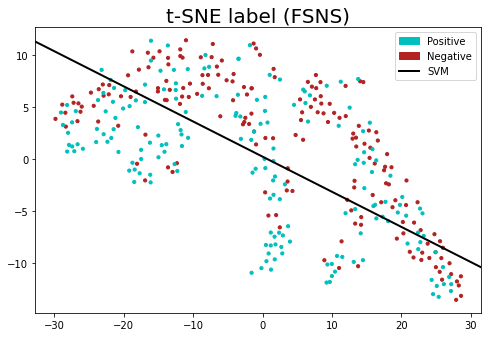

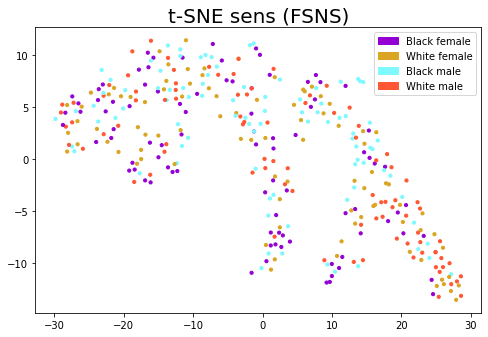

In [37]:

tsne = TSNE(n_jobs=16)

h = H(torch.tensor(features[:, ~sens_loc]).to(device))
h = h.cpu().detach().numpy()
h = StandardScaler().fit_transform(h) # normalizing the features

embedded = tsne.fit_transform(h)

vis_x = embedded[:, 0]
vis_y = embedded[:, 1]

print(sum(labels==1)/len(labels))

pop_a = mpatches.Patch(color='c', label='Positive')
pop_b = mpatches.Patch(color='firebrick', label='Negative')
#pop_c = mpatches.Arrow(color='black', label='SVM')

fig = plt.figure()
plt.scatter(vis_x, vis_y, c=np.array(['c' if i==1 else 'firebrick' for i in labels]), marker='.', s = 40)
x_lim = plt.gca().get_xlim()
y_lim = plt.gca().get_ylim()
#plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5)
plt.title('t-SNE label (FSNS)', fontsize = 20)

plt.tight_layout()
Fig = plt.gcf()
Fig.set_size_inches(7, 5, forward=True)

X = np.concatenate((vis_x.reshape(-1,1), vis_y.reshape(-1,1)), 1)
idx = np.array([i for i in range(len(X))])
np.random.shuffle(idx)
idx = idx[:int(len(idx)*0.75)]

svc = SVC(kernel='linear', C=500)
svc.fit(X[idx], labels[idx])

svm_pred = svc.predict(X[~idx])

print("ACC_y: {:.3f} ".format(sum(svm_pred == labels[~idx].reshape(-1))/len(labels[~idx])))

w = svc.coef_[0]
aa = -w[0] / w[1]
xx = np.linspace(x_lim[0], x_lim[1])
yy = aa * xx - svc.intercept_[0] / w[1]
y_lim = plt.gca().get_ylim()
plt.ylim(y_lim)
plt.xlim(x_lim)
svm = plt.plot(xx, yy, c='black', lw= 2, label = "SVM")
plt.legend(handles=[pop_a,pop_b, svm[0]])

# plt.savefig('fig/{}/tsne_label.png'.format(data_name))
plt.show()

colors_list = ['darkviolet', 'goldenrod', '#7DF9FF', '#FF5733']
cmap = colors.ListedColormap(colors_list)

norm = colors.Normalize(vmin=sens.min(), vmax=sens.max())

pop_a = mpatches.Patch(color=colors_list[0], label='Black female')
pop_b = mpatches.Patch(color=colors_list[1], label='White female')
pop_c = mpatches.Patch(color=colors_list[2], label='Black male')
pop_d = mpatches.Patch(color=colors_list[3], label='White male')

fig = plt.figure()
plt.scatter(vis_x, vis_y, c=sens, cmap=cmap, norm=norm, marker='.', s=40)
x_lim = plt.gca().get_xlim()
y_lim = plt.gca().get_ylim()
plt.title('t-SNE sens (FSNS)', fontsize=20)

plt.tight_layout()
Fig = plt.gcf()
Fig.set_size_inches(7, 5, forward=True)

X = np.concatenate((vis_x.reshape(-1,1), vis_y.reshape(-1,1)), 1)
idx = np.array([i for i in range(len(X))])
np.random.shuffle(idx)
idx = idx[:int(len(idx)*0.75)]

plt.legend(handles=[pop_a, pop_b, pop_c, pop_d])
plt.ylim(y_lim)
plt.xlim(x_lim)
# plt.savefig('fig/{}/tsne_sens.png'.format(data_name))
plt.show()
